In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
from datasets import SineDataset, CosineDataset, SineCosineDataset
from torch.utils.data import ConcatDataset, DataLoader
from tiny.diffusion import Diffusion
from tiny.models import ClassConditionalPointCloudDiT
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
def plot_point_clouds(point_clouds: torch.Tensor, rows: int, cols: int):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.ravel()
    dim = point_clouds.shape[2]
    point_clouds = point_clouds.cpu()

    for idx, ax in enumerate(axes):
        if idx < len(point_clouds):

            if dim == 2:
                X, Y = point_clouds[idx, :, 0], point_clouds[idx, :, 1]
                ax.scatter(X, Y)
            elif dim == 3:
                X, Y, Z = (
                    point_clouds[idx, :, 0],
                    point_clouds[idx, :, 1],
                    point_clouds[idx, :, 2],
                )
                ax.scatter(X, Y, Z)

            ax.axis("equal")  # Ensures that the scale of x and y axes are the same
        else:
            ax.axis("off")  # Turn off axis if there's no data to plot

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters())

In [5]:
num_points = 128
# dataset = SineCosineDataset(num_points=num_points, size=1024)
sine_dataset = SineDataset(num_points=num_points, size=15000)
cosine_dataset = CosineDataset(num_points=num_points, size=15000)
dataset = sine_dataset
dataset = cosine_dataset
dataset = ConcatDataset([sine_dataset, cosine_dataset])

dataloader = DataLoader(dataset, collate_fn=sine_dataset.collate, batch_size=128, shuffle=True)

In [7]:
diffusion = Diffusion(
    schedule_type="linear",
    num_timesteps=1000
)

model = ClassConditionalPointCloudDiT(input_size=num_points, in_channels=2, depth=1, num_heads=1, 
                                      num_classes=2,
                                      class_embedding_dim=32, hidden_size=32).to("cuda")

count_parameters(model)

27682

In [8]:
model(torch.randn(1, num_points, 2).to("cuda"), torch.tensor([0]).to("cuda"), torch.tensor([0]).to("cuda")).shape

torch.Size([1, 128, 2])

In [9]:
num_epochs = 20
model = model.to("cuda")
diffusion = diffusion.to("cuda")
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

with tqdm(total=num_epochs * len(dataloader)) as pbar:
    for epoch in range(num_epochs):
        for batch in dataloader:
            X = batch["data"].to("cuda")
            classes = batch["labels"].long().to("cuda")


            # if prob is less than 0.1 set classes to None
            if torch.rand(1).item() < 0.1:
                classes = None
        
            t = torch.randint(0, 1000, (X.shape[0],)).long().to("cuda")
            loss = diffusion.training_losses(model, X, t, cond=classes)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.update(1)
            pbar.set_postfix({"loss": loss.item()})

  0%|          | 7/4700 [00:00<09:08,  8.55it/s, loss=0.928]

100%|██████████| 4700/4700 [00:22<00:00, 209.91it/s, loss=0.161] 


  4%|▍         | 43/1000 [00:00<00:02, 428.87it/s]

100%|██████████| 1000/1000 [00:02<00:00, 434.84it/s]


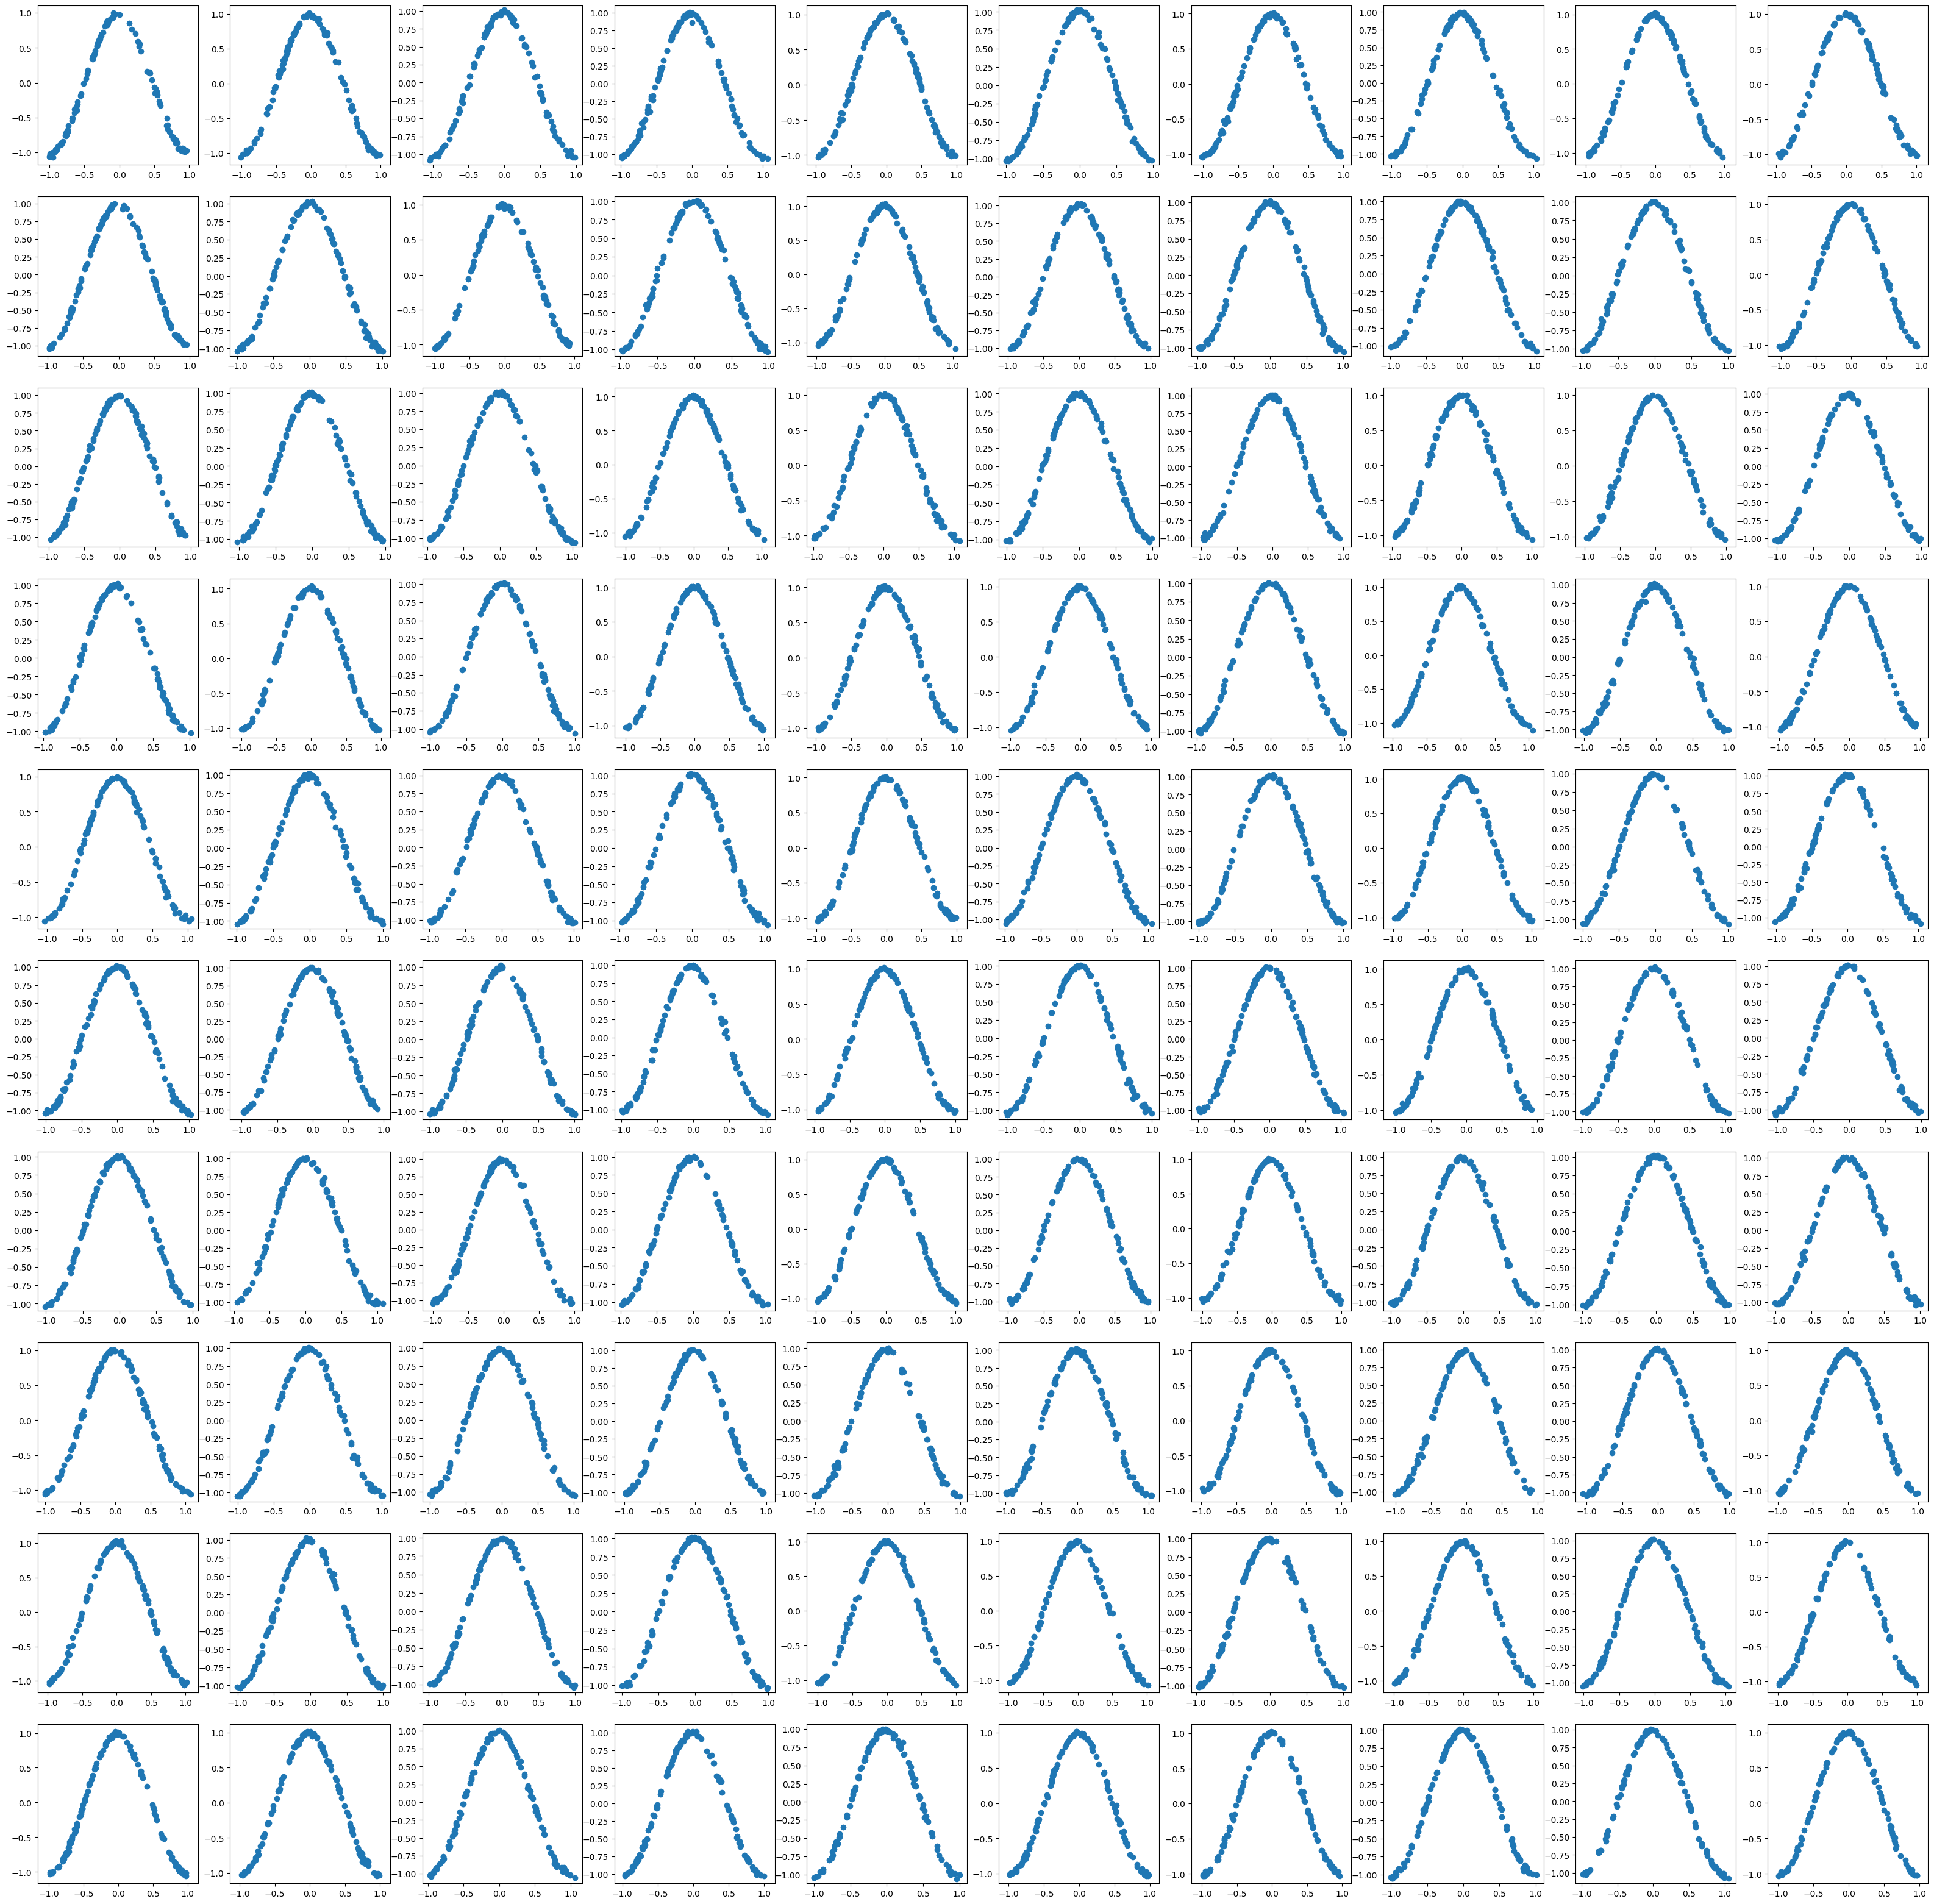

In [11]:
samples = diffusion.p_sample_loop(model, (100, num_points, 2), cond=torch.full((100, ), 1, device="cuda"), clip_denoised=False)
# samples = diffusion.p_sample_loop(model, (100, num_points, 2), cond=torch clip_denoised=False)
plot_point_clouds(samples, 10, 10)